In [1]:
from os.path import join
from itertools import product
from copy import deepcopy
from rich.progress import track

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LogisticRegression

from mlresearch.utils import set_matplotlib_style, parallel_loop
from recgame.recourse import NFeatureRecourse
from recgame.populations import BasePopulation
from recgame.environments import (
    BankLoanApplication2,
    BankLoanApplication3,
    WillingnessEnvironment,
)
from recgame.visualization import (
    simulations_scores_panel,
    simulations_success_rate_panels,
)
from recgame.utils import generate_synthetic_data

In [16]:
SAVE_PATH = "../assets/multi-agent-dynamic-counterfactual-recourse/analysis/"
set_matplotlib_style(16, **{"lines.markersize": 1, "axes.labelsize": 32, "legend.fontsize": 16})

# Some variables to define the problem
RNG_SEED = 42
N_CONTINUOUS = 2
N_CAT = 0
N_AGENTS = 100

df, y, categorical = generate_synthetic_data(N_AGENTS, N_CONTINUOUS, N_CAT, RNG_SEED)

lr = LogisticRegression(random_state=RNG_SEED).fit(df, y)

In [3]:
population = BasePopulation(df, categorical=categorical)

# Remove upper and lower bounds
population.action_set_.ub = [1.5, 1.5]
population.action_set_.lb = [0, 0]

recourse = NFeatureRecourse(lr, n_features=2)

# Bank Loan application - Gaussian adaptation

In [4]:
# Meta-simulation variables
N_LOANS_BLA3 = [10]  # number of loans is fixed
ADAPTATION_BLA3 = [0.1, 0.3, 0.5, 0.7, 0.9]
NEW_AGENTS_BLA3 = [8, 9, 10, 11, 12]
N_LOANS_BLA3, ADAPTATION_BLA3, NEW_AGENTS_BLA3

([10], [0.1, 0.3, 0.5, 0.7, 0.9], [8, 9, 10, 11, 12])

In [5]:
def _meta_simulation(params):
    loans, adapt, agents = params
    environment = BankLoanApplication3(
        deepcopy(population),
        deepcopy(recourse),
        n_loans=loans,
        adaptation=adapt,
        new_agents=agents,
        random_state=RNG_SEED,
    )
    try:
        environment.run_simulation(50)
    except ValueError:
        pass

    return {"n_loans": loans, "adaptation": adapt, "new_agents": agents}, environment


results_bla3 = parallel_loop(
    _meta_simulation,
    list(product(N_LOANS_BLA3, ADAPTATION_BLA3, NEW_AGENTS_BLA3)),
    n_jobs=-1,
    progress_bar=True,
    description=None,
)

Output()

Output()

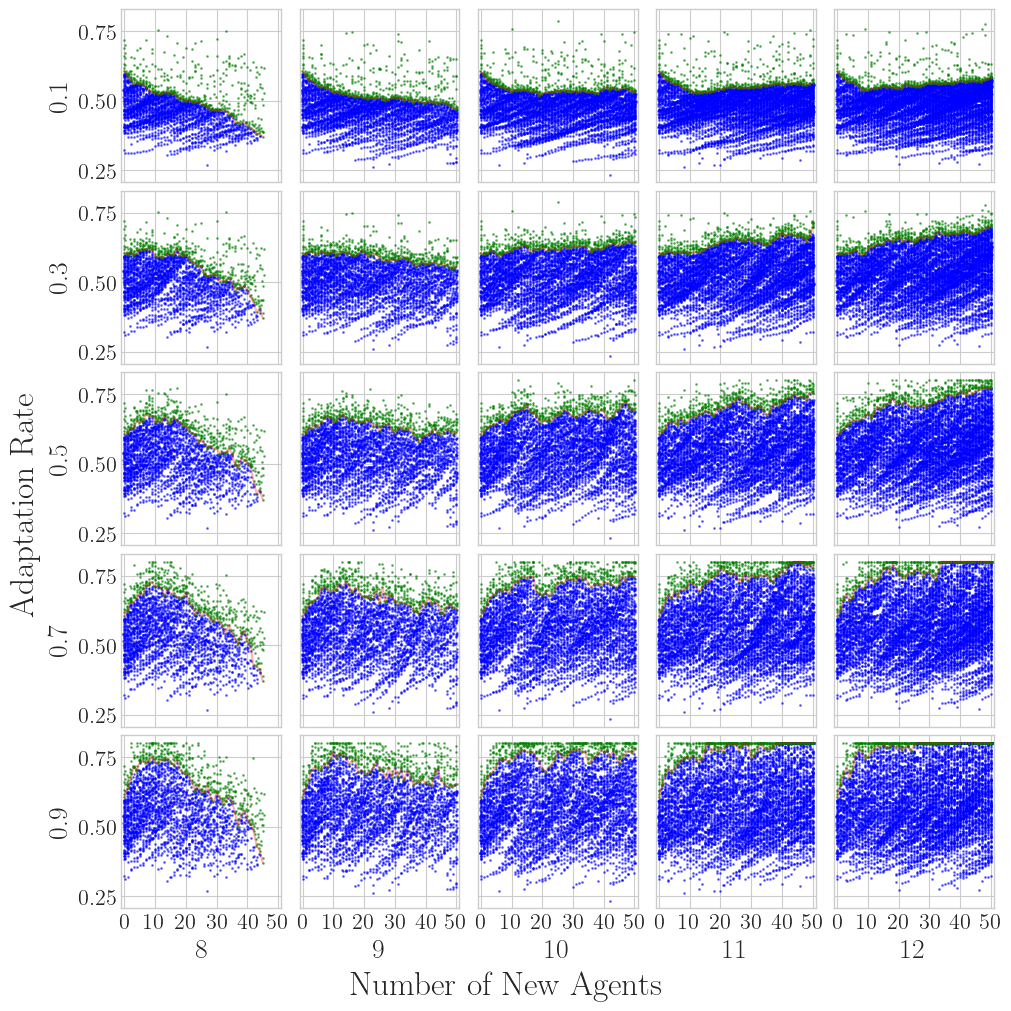

In [29]:
fig, axes = simulations_scores_panel(results_bla3, ADAPTATION_BLA3, NEW_AGENTS_BLA3)
fig.supxlabel(r"Number of New Agents")
fig.supylabel(r"Adaptation Rate")
plt.savefig(
    join(SAVE_PATH, "single_run_gaussian_adaptation_scores_panel.jpeg"),
    dpi=200,
    format="jpeg",
    bbox_inches="tight",
)
plt.show()

Output()

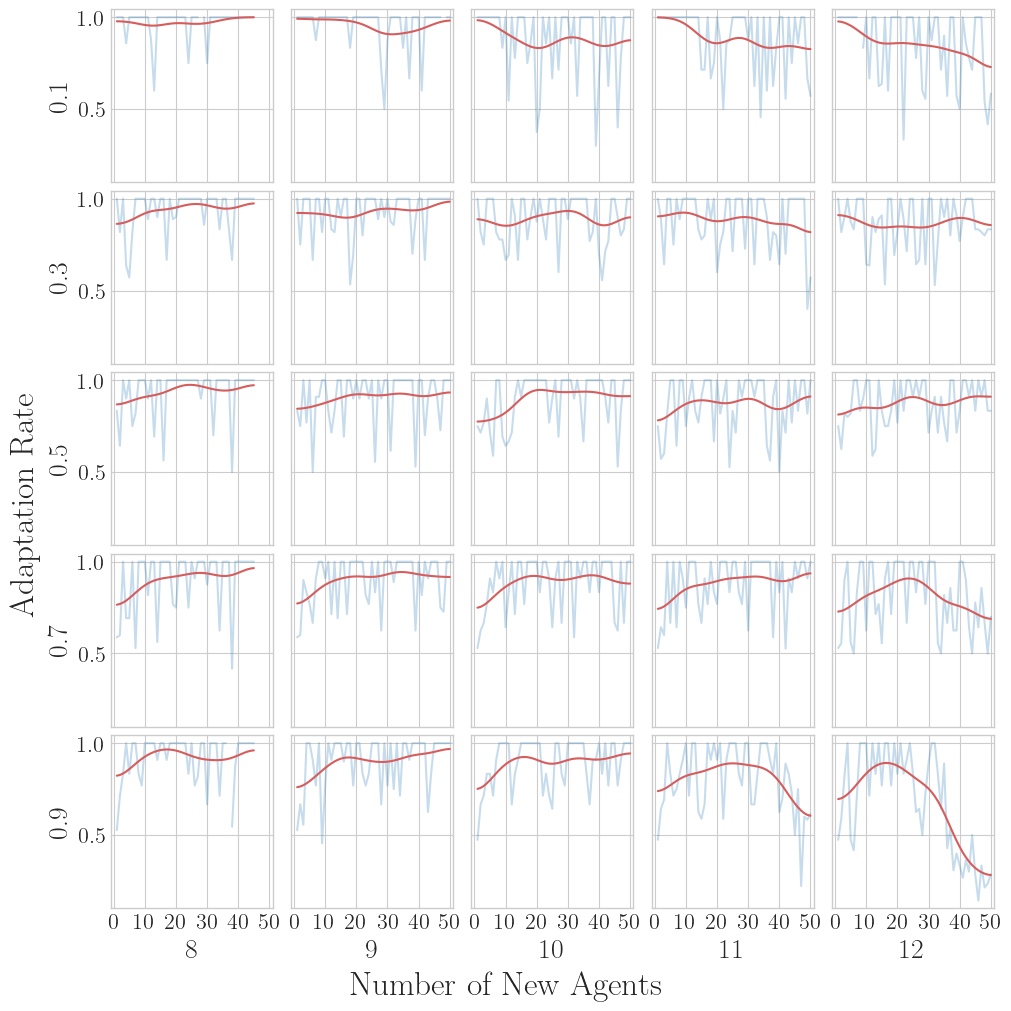

In [30]:
fig, axes = simulations_success_rate_panels(results_bla3, ADAPTATION_BLA3, NEW_AGENTS_BLA3)
fig.supxlabel(r"Number of New Agents")
fig.supylabel(r"Adaptation Rate")
plt.savefig(
    join(SAVE_PATH, "single_run_gaussian_adaptation_success_panel.pdf"),
    format="pdf",
    bbox_inches="tight",
)
plt.show()

# Bank Loan application - Binary adaptation

In [8]:
# Meta-simulation variables
N_LOANS_BLA2 = [10]  # number of loans is fixed
ADAPTATION_BLA2 = [8, 9, 10, 11, 12]
NEW_AGENTS_BLA2 = [8, 9, 10, 11, 12]
N_LOANS_BLA2, ADAPTATION_BLA2, NEW_AGENTS_BLA2

([10], [8, 9, 10, 11, 12], [8, 9, 10, 11, 12])

In [9]:
def _meta_simulation(params):
    loans, adapt, agents = params
    environment = BankLoanApplication2(
        deepcopy(population),
        deepcopy(recourse),
        n_loans=loans,
        adaptation=adapt,
        new_agents=agents,
        random_state=RNG_SEED,
    )
    try:
        environment.run_simulation(50)
    except (ValueError, KeyError):
        pass

    return {"n_loans": loans, "adaptation": adapt, "new_agents": agents}, environment


results_bla2 = parallel_loop(
    _meta_simulation,
    list(product(N_LOANS_BLA2, ADAPTATION_BLA2, NEW_AGENTS_BLA2)),
    n_jobs=-1,
    progress_bar=True,
    description=None,
)

Output()

Output()

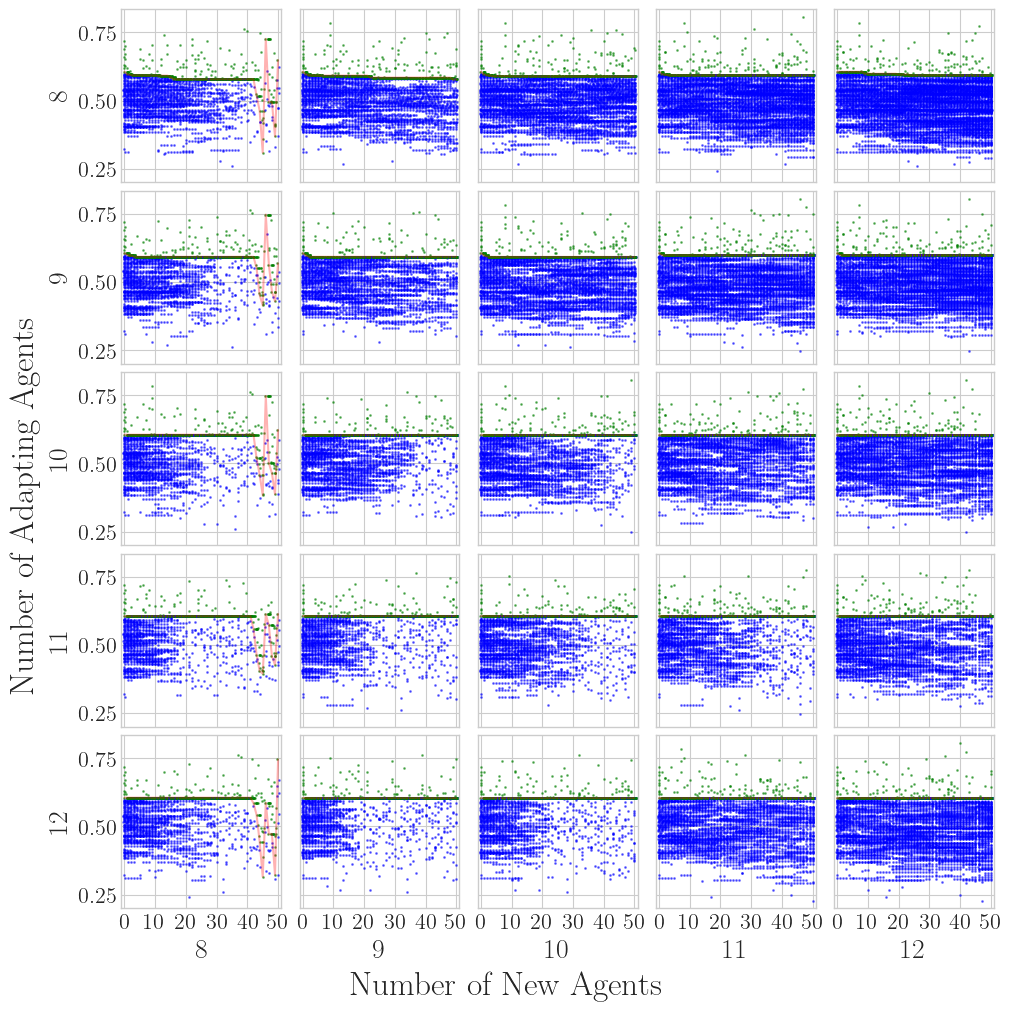

In [31]:
fig, axes = simulations_scores_panel(results_bla2, ADAPTATION_BLA2, NEW_AGENTS_BLA2)
fig.supxlabel(r"Number of New Agents")
fig.supylabel(r"Number of Adapting Agents")
plt.savefig(
    join(SAVE_PATH, "single_run_binary_adaptation_scores_panel.jpeg"),
    dpi=200,
    format="jpeg",
    bbox_inches="tight",
)
plt.show()

Output()

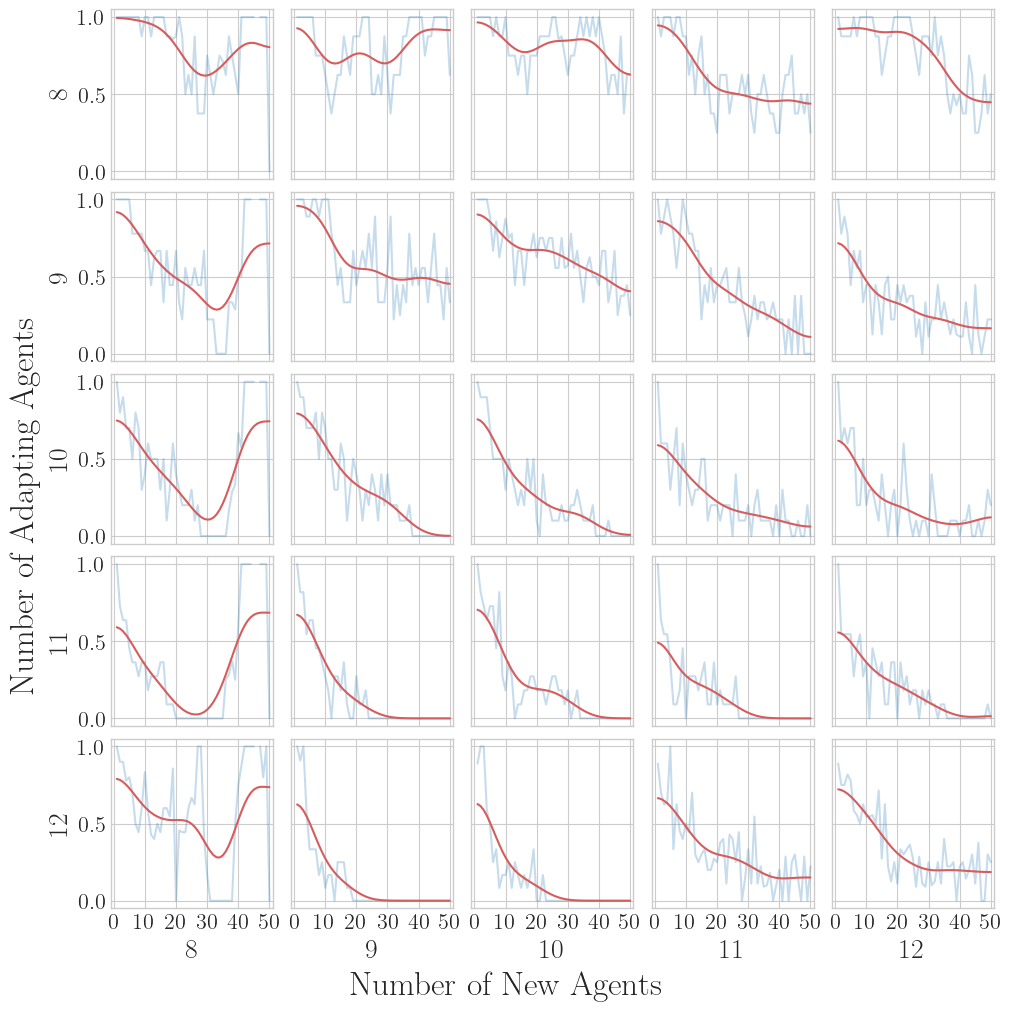

In [32]:
fig, axes = simulations_success_rate_panels(results_bla2, ADAPTATION_BLA2, NEW_AGENTS_BLA2)
fig.supxlabel(r"Number of New Agents")
fig.supylabel(r"Number of Adapting Agents")
plt.savefig(
    join(SAVE_PATH, "single_run_binary_adaptation_success_panel.pdf"),
    format="pdf",
    bbox_inches="tight",
)
plt.show()

# Willingness Environment

In [12]:
# Meta-simulation variables
N_LOANS_WILL = [10]  # number of loans is fixed
ADAPTATION_WILL = [0.1, 0.3, 0.5, 0.7, 0.9]
NEW_AGENTS_WILL = [8, 9, 10, 11, 12]
N_LOANS_WILL, ADAPTATION_WILL, NEW_AGENTS_WILL

([10], [0.1, 0.3, 0.5, 0.7, 0.9], [8, 9, 10, 11, 12])

In [13]:
def _meta_simulation(params):
    loans, adapt, agents = params
    environment = WillingnessEnvironment(
        deepcopy(population),
        deepcopy(recourse),
        n_loans=loans,
        adaptation=adapt,
        new_agents=agents,
        random_state=RNG_SEED,
    )
    try:
        environment.run_simulation(50)
    except ValueError:
        pass

    return {"n_loans": loans, "adaptation": adapt, "new_agents": agents}, environment


results_will = parallel_loop(
    _meta_simulation,
    list(product(N_LOANS_WILL, ADAPTATION_WILL, NEW_AGENTS_WILL)),
    n_jobs=-1,
    progress_bar=True,
    description=None,
)

Output()

Output()

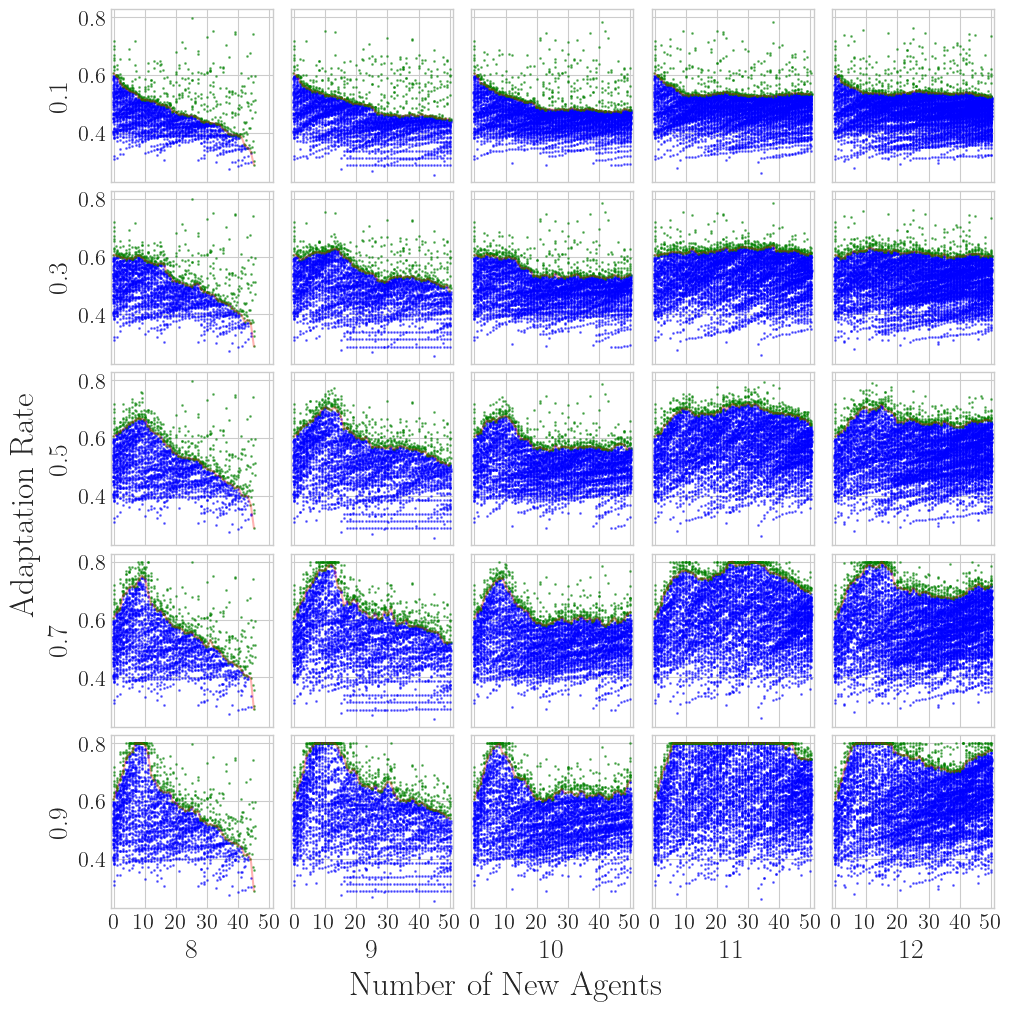

In [33]:
fig, axes = simulations_scores_panel(results_will, ADAPTATION_WILL, NEW_AGENTS_WILL)
fig.supxlabel(r"Number of New Agents")
fig.supylabel(r"Adaptation Rate")
plt.savefig(
    join(SAVE_PATH, "single_run_willingness_adaptation_scores_panel.jpeg"),
    dpi=200,
    format="jpeg",
    bbox_inches="tight",
)
plt.show()

Output()

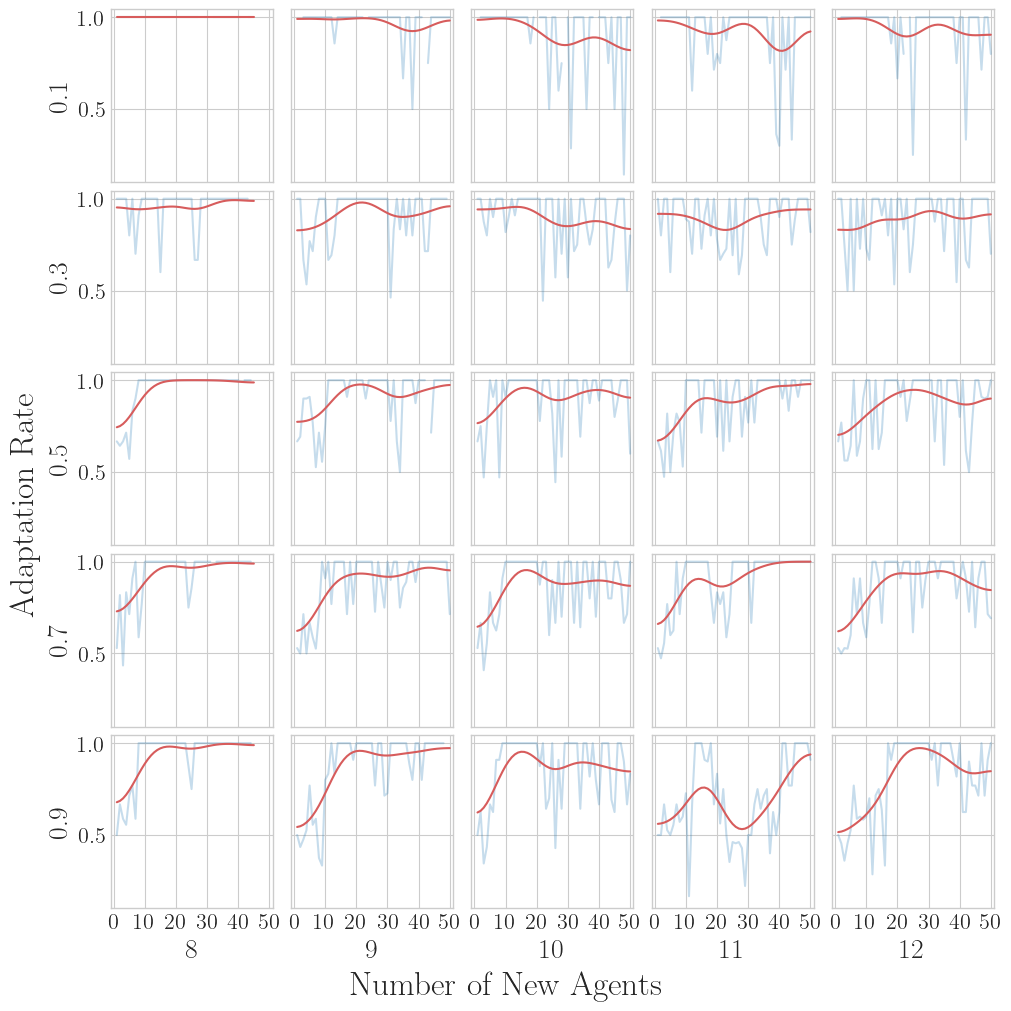

In [34]:
fig, axes = simulations_success_rate_panels(results_will, ADAPTATION_WILL, NEW_AGENTS_WILL)
fig.supxlabel(r"Number of New Agents")
fig.supylabel(r"Adaptation Rate")
plt.savefig(
    join(SAVE_PATH, "single_run_willingness_adaptation_success_panel.pdf"),
    format="pdf",
    bbox_inches="tight",
)
plt.show()